# Homework 5：高校分群、华东师范大学画像与学科排名预测

## 任务概述与分析思路

本 Notebook 继承 homework_4 的数据库，完成以下三个核心任务：

### 任务 8：全球高校聚类分群与ECNU相似高校检索
**分析目标**：基于学科表现数据对全球高校进行无监督聚类，识别不同类型的大学群体，并找出与华东师范大学相似的高校。

**方法选择理由**：
- 使用 K-Means 聚类：适合处理高维数值特征，能够发现球形簇结构
- 特征工程：构建多维度特征矩阵（排名百分位、引用标准化、顶级论文占比）
- 相似度检索：采用余弦相似度，更适合高维稀疏特征的相似性度量

### 任务 9：华东师范大学学科画像构建
**分析目标**：通过多角度数据分析，为华东师范大学构建comprehensive学科实力画像。

**分析维度**：
- 学科覆盖广度：统计涉及的ESI学科数量
- 优势学科识别：找出排名前20%的学科领域
- 相对位置分析：与全球平均水平和同类高校的对比
- 可视化展示：通过图表直观展现学科实力分布

### 任务 10：学科排名预测建模
**分析目标**：构建机器学习模型，基于学术产出指标预测各学科的ESI排名。

**建模策略**：
- 特征工程：对数变换处理偏态分布，标准化数值特征
- 模型选择：树模型（随机森林、梯度提升）适合处理非线性关系和特征交互
- 评估指标：MAE（平均绝对误差）、RMSE、Spearman相关系数综合评估
- 按学科建模：考虑不同学科的评价标准差异

## 1. 数据基础：连接数据库并加载ESI数据

本节将从当前目录 `./config.json` 读取连接信息，连接 MySQL 并载入表 `esi_data` 的核心字段到 pandas。

In [30]:
# 基础导入与缓存路径
import os, json, math, pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr
import joblib
CACHE_DIR = pathlib.Path("results/cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)
DATA_FIELDS = [
    "subject_rank","institution","country_region","web_of_science_documents","cites","cites_per_paper","top_papers","filter_value",
]

def load_db_config():
    """只从当前工作目录读取 ./config.json，找到即加载并打印路径。"""
    p = (pathlib.Path.cwd() / "config.json").resolve()
    if p.exists():
        print(f"Using config: {p}")
        with open(p, "r", encoding="utf-8") as f:
            return json.load(f)
    raise FileNotFoundError("未找到配置文件。请将 config.json 放在当前工作目录（homework_5/）下。")

def get_engine(cfg):
    user = cfg["mysql_user"]; pwd = cfg["mysql_password"]; host = cfg["mysql_host"]; db = cfg["mysql_db"]
    url = f"mysql+pymysql://{user}:{pwd}@{host}/{db}?charset=utf8mb4"
    return create_engine(url)

def load_esi_dataframe(force_reload=False):
    feather_path = CACHE_DIR/"esi_data.feather"
    parquet_path = CACHE_DIR/"esi_data.parquet"
    if not force_reload and (feather_path.exists() or parquet_path.exists()):
        try:
            if feather_path.exists():
                return pd.read_feather(feather_path)
            else:
                return pd.read_parquet(parquet_path)
        except Exception:
            pass
    cfg = load_db_config()
    engine = get_engine(cfg)
    sql = "SELECT " + ",".join(DATA_FIELDS) + " FROM esi_data"
    df = pd.read_sql(sql, engine)
    return df

df = load_esi_dataframe(force_reload=False)
display(df.head(), df.shape)

,subject_rank,institution,country_region,web_of_science_documents,cites,cites_per_paper,top_papers,filter_value
0,1,CHINESE ACADEMY OF SCIENCES,CHINA MAINLAND,15661,332254,21.22,251,AGRICULTURAL SCIENCES
1,2,CHINESE ACADEMY OF AGRICULTURAL SCIENCES,CHINA MAINLAND,12222,223855,18.32,198,AGRICULTURAL SCIENCES
2,3,UNITED STATES DEPARTMENT OF AGRICULTURE (USDA),USA,12564,220644,17.56,105,AGRICULTURAL SCIENCES
3,4,CHINA AGRICULTURAL UNIVERSITY,CHINA MAINLAND,10052,207779,20.67,166,AGRICULTURAL SCIENCES
4,5,INRAE,FRANCE,9314,187838,20.17,118,AGRICULTURAL SCIENCES


(34121, 8)

## 2. 数据预处理：清洗、标准化与特征衍生

### 2.1 数据质量问题与解决方案

**处理策略**：
- **去重**：基于 (institution, filter_value, subject_rank) 组合去重
- **文本标准化**：去除首尾空格，统一未知值标记
- **类型转换**：确保数值字段为 numeric 类型
- **缺失值填充**：根据业务逻辑进行合理填充

### 2.2 关键衍生指标说明
- **max_rank**：每个学科的最大排名，用于计算相对位置
- **rank_percentile**：排名百分位 = (rank-1)/(max_rank-1)，标准化不同学科的排名尺度
  - 值越小表示排名越靠前（0表示第1名，1表示末位）
  - 解决不同学科排名总数不同的问题

主要步骤：
- 去重、空值检查与基本填充
- 文本字段规范化（去两端空白、统一大小写策略）
- 数值字段类型转换
- 每学科计算 `max_rank` 与 `rank_percentile = (rank-1)/(max_rank-1)`

In [31]:
def clean_and_enrich(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    # 去重
    d = d.drop_duplicates()
    # 文本标准化
    for col in ["institution", "country_region", "filter_value"]:
        if col in d.columns:
            d[col] = d[col].astype(str).str.strip()
            # 保持原有大小写，但空字符串填为 UNKNOWN（国家/地区）；院校可保留空值以便后续剔除
    # 注意：上面已将 None/NaN 转成字符串 'None'/'nan'，因此这里用字符串替换
    d["country_region"] = d["country_region"].replace(["", "nan", "None"], "UNKNOWN")
    # 数值字段类型
    for col in ["subject_rank","web_of_science_documents","cites","top_papers"]:
        if col in d.columns:
            d[col] = pd.to_numeric(d[col], errors="coerce")
    if "cites_per_paper" in d.columns:
        d["cites_per_paper"] = pd.to_numeric(d["cites_per_paper"], errors="coerce")
    # 删除缺少关键字段的行
    d = d.dropna(subset=["subject_rank", "institution", "filter_value"])
    # 计算每学科的 max_rank
    d["max_rank"] = d.groupby("filter_value")["subject_rank"].transform("max")
    # 防止分母为0
    d["rank_percentile"] = (d["subject_rank"] - 1) / (d["max_rank"].replace(1, np.nan) - 1)
    d["rank_percentile"] = d["rank_percentile"].fillna(0.0).clip(0, 1)
    return d
df_clean = clean_and_enrich(df)
display(df_clean.head(), df_clean.isna().sum())

,subject_rank,institution,country_region,web_of_science_documents,cites,cites_per_paper,top_papers,filter_value,max_rank,rank_percentile
0,1,CHINESE ACADEMY OF SCIENCES,CHINA MAINLAND,15661,332254,21.22,251,AGRICULTURAL SCIENCES,1381,0.000000
1,2,CHINESE ACADEMY OF AGRICULTURAL SCIENCES,CHINA MAINLAND,12222,223855,18.32,198,AGRICULTURAL SCIENCES,1381,0.000725
2,3,UNITED STATES DEPARTMENT OF AGRICULTURE (USDA),USA,12564,220644,17.56,105,AGRICULTURAL SCIENCES,1381,0.001449
3,4,CHINA AGRICULTURAL UNIVERSITY,CHINA MAINLAND,10052,207779,20.67,166,AGRICULTURAL SCIENCES,1381,0.002174
4,5,INRAE,FRANCE,9314,187838,20.17,118,AGRICULTURAL SCIENCES,1381,0.002899


subject_rank                0
institution                 0
country_region              0
web_of_science_documents    0
cites                       0
cites_per_paper             0
top_papers                  0
filter_value                0
max_rank                    0
rank_percentile             0
dtype: int64

## 3. 特征工程：构建高校×学科特征矩阵

### 3.1 特征设计思路
构建多维度特征矩阵，以 institution 为行、filter_value 为列，每个特征反映不同角度的学术表现：

**三类核心特征**：
1. **排名特征 (rank_percentile)**：
   - 反映学科排名相对位置
   - 缺失值填充1.0（表示该学科排名末位或无数据）
   - 越小越好（0表示第1名）

2. **引用质量特征 (cites_per_paper z-score)**：
   - 篇均引用数在学科内的标准化得分
   - 消除不同学科引用习惯差异
   - 反映论文影响力质量

3. **顶级论文占比 (top_papers_rate)**：
   - 高被引论文数量在学科内的相对占比
   - 反映产出卓越研究的能力
   - 归一化到[0,1]区间

### 3.3 标准化必要性
- 不同特征量纲差异大
- 确保聚类算法中各特征权重均衡
- 提高数值计算稳定性

具体实现：
- 以 institution 为行、filter_value 为列构建多组特征
- 合并三组特征，并整体做 StandardScaler

In [32]:
def build_feature_matrices(d: pd.DataFrame):
    # rank_percentile pivot
    mat_rank = d.pivot_table(index="institution", columns="filter_value", values="rank_percentile", aggfunc="min")
    mat_rank = mat_rank.fillna(1.0)
    # cites_per_paper -> zscore within subject
    d_cp = d.copy()
    d_cp["cpp_z"] = d_cp.groupby("filter_value")["cites_per_paper"].transform(lambda x: (x - x.mean())/x.std(ddof=0) if x.std(ddof=0) not in [0, np.nan] else 0)
    mat_cpp = d_cp.pivot_table(index="institution", columns="filter_value", values="cpp_z", aggfunc="mean").fillna(0.0)
    # top_papers rate within subject
    d_tp = d.copy()
    d_tp["tp_rate"] = d_tp["top_papers"] / d_tp.groupby("filter_value")["top_papers"].transform("max")
    d_tp["tp_rate"] = d_tp["tp_rate"].replace([np.inf, -np.inf], np.nan).fillna(0.0).clip(0, 1)
    mat_tp = d_tp.pivot_table(index="institution", columns="filter_value", values="tp_rate", aggfunc="mean").fillna(0.0)
    # 对三块特征做列名前缀
    mat_rank.columns = pd.MultiIndex.from_product([["rank"], mat_rank.columns])
    mat_cpp.columns = pd.MultiIndex.from_product([["cppz"], mat_cpp.columns])
    mat_tp.columns = pd.MultiIndex.from_product([["tpr"], mat_tp.columns])
    # 合并
    mat = pd.concat([mat_rank, mat_cpp, mat_tp], axis=1).sort_index(axis=1)
    # 标准化
    scaler = StandardScaler(with_mean=True, with_std=True)
    mat_std = pd.DataFrame(scaler.fit_transform(mat.fillna(0.0)), index=mat.index, columns=mat.columns)
    return mat, mat_std, scaler
mat, mat_std, scaler = build_feature_matrices(df_clean)
display(mat.shape, mat_std.shape)

(9990, 66)

(9990, 66)

## 4. 任务8.1：全球高校聚类分群

### 4.1 聚类方法选择：K-Means
**为什么选择K-Means？**
- **适用性**：处理连续数值特征，计算效率高
- **可解释性**：簇中心具有明确含义，代表典型的高校学术特征
- **稳定性**：结果可重现，便于后续分析

### 4.2 最优簇数选择策略
**评价指标选择**：
1. **轮廓系数 (Silhouette Score)**：
   - 衡量簇内紧密度和簇间分离度
   - 取值范围[-1,1]，越大越好
   - 直观反映聚类质量

2. **Calinski-Harabasz指数**：
   - 基于簇间和簇内方差比
   - 值越大表示簇间差异越明显
   - 对球形簇效果较好

**搜索范围设置**：k=3..12
- k<3：分群过少，无法体现差异性
- k>12：分群过细，可能过拟合，实际意义不大

### 4.3 聚类结果的业务解释
不同簇可能代表：
- 综合性研究型大学（多学科均衡发展）
- 专业特色型大学（少数学科突出）
- 新兴大学（部分学科有潜力）
- 传统强校（传统优势学科明显）

技术实现：
- 尝试 KMeans(k=3..12)，评估轮廓系数与 Calinski-Harabasz 指标，选择较优 k
- 固定 random_state 确保复现
- 为每所高校赋予 cluster 标签并保存

In [33]:
def kmeans_cluster_search(X: pd.DataFrame, k_range=range(3, 13), random_state=42):
    metrics = []
    best = None
    for k in k_range:
        km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        labels = km.fit_predict(X)
        try:
            sil = silhouette_score(X, labels)
        except Exception:
            sil = np.nan
        try:
            ch = calinski_harabasz_score(X, labels)
        except Exception:
            ch = np.nan
        metrics.append({"k": k, "silhouette": sil, "calinski_harabasz": ch})
        if best is None or (not np.isnan(sil) and sil > best["silhouette"]):
            best = {"k": k, "silhouette": sil, "calinski_harabasz": ch, "model": km, "labels": labels}
    return pd.DataFrame(metrics), best
metrics_df, best = kmeans_cluster_search(mat_std, k_range=range(3, 13), random_state=42)
display(metrics_df.sort_values(["silhouette","calinski_harabasz"], ascending=[False, False]).head(5))
cluster_k = best["k"] if isinstance(best, dict) else 5
cluster_labels = best["labels"] if isinstance(best, dict) else KMeans(n_clusters=cluster_k, random_state=42).fit_predict(mat_std)
inst_cluster = pd.DataFrame({"institution": mat_std.index, "cluster": cluster_labels}).set_index("institution")
inst_cluster.to_csv("results/institution_clusters.csv", index=True)
display(inst_cluster['cluster'].value_counts().sort_index())

,k,silhouette,calinski_harabasz
0,3,0.647174,1984.340888
1,4,0.620853,1548.677010
3,6,0.494878,1141.267901
5,8,0.488086,935.897679
2,5,0.487309,1301.036186


cluster
0    9215
1      90
2     685
Name: count, dtype: int64

## 5. 任务8.2：华东师范大学相似高校检索

### 5.1 相似度度量选择：余弦相似度
**为什么选择余弦相似度？**
- **高维适用性**：在高维稀疏空间中表现优异
- **尺度无关性**：关注特征模式而非绝对数值大小
- **语义合理性**：两个向量夹角越小，学科发展模式越相似

### 5.2 检索策略设计
**最近邻算法选择**：
- 使用 scikit-learn 的 NearestNeighbors
- 预计算距离矩阵，提高查询效率
- 支持多种距离度量，便于比较

**过滤机制**：
- **排除自身**：避免返回目标高校本身
- **同国家限制**（可选）：寻找同一国家内的相似高校
- **簇内搜索**（可选）：在同一聚类簇内寻找相似高校

### 5.3 结果解释与验证
**相似性的含义**：
- 学科布局相似：在相近的学科领域有较强实力
- 发展模式相似：各学科的相对实力分布接近
- 发展水平相似：整体学术影响力在同一层次

**验证方法**：
- 查看相似高校的地理分布
- 分析相似高校的办学性质和历史
- 对比相似高校的具体学科优势

技术实现：
- 在标准化特征空间用余弦相似度检索最近邻
- 支持排除同校、限制同国家等过滤
- 导出相似高校清单

In [34]:
def find_similar_institutions(target="EAST CHINA NORMAL UNIVERSITY", n_neighbors=10, exclude_same=True, same_country_only=False):
    X = mat_std.loc[:, :].values
    names = mat_std.index.tolist()
    nn = NearestNeighbors(metric='cosine', n_neighbors=min(n_neighbors+1, len(names)))
    nn.fit(X)
    if target not in names:
        print(f"未找到高校：{target}")
        return pd.DataFrame()
    idx = names.index(target)
    dists, idxs = nn.kneighbors(X[idx:idx+1], return_distance=True)
    pairs = []
    for dist, j in zip(dists[0], idxs[0]):
        inst = names[j]
        if exclude_same and inst == target:
            continue
        pairs.append((inst, 1.0 - dist))  # 余弦相似度 = 1 - 距离
    out = pd.DataFrame(pairs, columns=["institution", "cosine_similarity"])
    out["cluster"] = inst_cluster.loc[out["institution"], "cluster"].values
    # 可选过滤：同国家
    if same_country_only:
        # 用 df_clean 中 institution->country_region 的众数
        cr_map = df_clean.groupby("institution")["country_region"].agg(lambda x: x.mode().iat[0] if not x.mode().empty else x.iloc[0])
        tgt_country = cr_map.get(target, None)
        if tgt_country is not None:
            out = out[out["institution"].map(cr_map) == tgt_country]
    out = out.sort_values("cosine_similarity", ascending=False).head(n_neighbors)
    out.to_csv("results/similar_to_ECNU.csv", index=False)
    display(out)
    return out
_ = find_similar_institutions("EAST CHINA NORMAL UNIVERSITY", n_neighbors=15)

,institution,cosine_similarity,cluster
0,NANJING NORMAL UNIVERSITY,0.889943,2
1,BEIJING NORMAL UNIVERSITY,0.867665,2
2,UNIVERSITY OF VICTORIA,0.858124,2
3,TECHNICAL UNIVERSITY OF BERLIN,0.845337,2
4,LANZHOU UNIVERSITY,0.835177,2
5,GUANGZHOU UNIVERSITY,0.834240,2
6,SOUTH CHINA NORMAL UNIVERSITY,0.832951,2
7,NORWEGIAN UNIVERSITY OF SCIENCE & TECHNOLOGY (...,0.824745,2
8,SOUTHWEST UNIVERSITY - CHINA,0.824578,2
9,UNIVERSITY OF WATERLOO,0.816400,2


## 6. 任务9：华东师范大学学科画像构建

### 6.1 画像构建思路
**多维度分析框架**：
1. **学科覆盖度分析**：统计ESI入榜学科数量，反映学科门类齐全程度
2. **优势学科识别**：基于rank_percentile阈值，识别排名前20%的优势学科
3. **相对位置分析**：与全球平均水平、同簇高校对比，找准定位
4. **发展潜力评估**：结合引用趋势、论文增长等指标

### 6.2 关键指标设计
**核心统计指标**：
- **subject_coverage**：入榜学科总数（rank_percentile < 1.0）
- **top_subject_count**：优势学科数量（rank_percentile ≤ 0.2）
- **top_subjects**：具体优势学科名单

**比较基准选择**：
- **全局均值**：反映在全球高校中的相对位置
- **同簇均值**：反映在相似类型高校中的相对位置
- 提供不同维度的参考标准

### 6.3 可视化策略
**图表类型选择**：
1. **条形图**：展示最强/最弱学科排名
   - 直观对比不同学科表现
   - 识别明显的优势和劣势领域

2. **雷达图**（可扩展）：多维度综合展示
   - 各学科排名百分位分布
   - 与基准的多维对比

3. **热力图**（可扩展）：学科-指标矩阵
   - 排名、引用、产出的综合视图

### 6.4 画像解读框架
**强势学科特征**：rank_percentile ≤ 0.2
**中等学科特征**：0.2 < rank_percentile ≤ 0.6  
**待发展学科**：rank_percentile > 0.6

通过画像可以回答：
- ECNU的学科优势在哪里？
- 与同类高校相比有何特色？
- 未来发展的重点方向是什么？

技术实现：
- 指标：rank_percentile 分布、Top x% 学科数量、学科覆盖面
- 与全局/同簇均值对比
- 可视化：条形图、雷达图、热力图

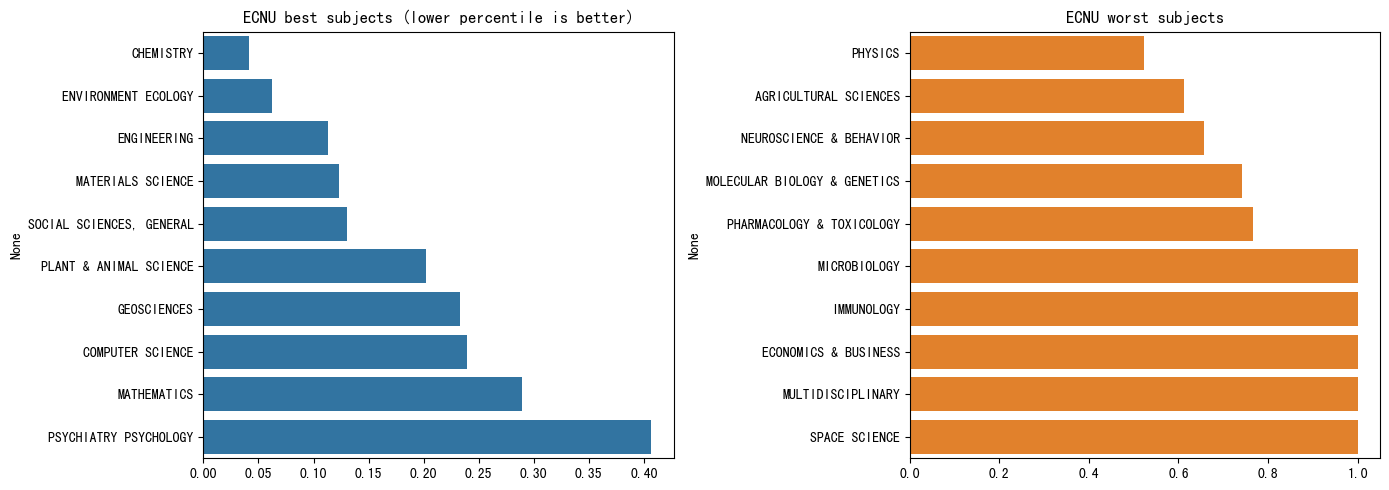

{'summary': {'subject_coverage': 17, 'top_pct': 0.2, 'top_subject_count': 5},
 'top_subjects': ['CHEMISTRY',
  'ENGINEERING',
  'ENVIRONMENT ECOLOGY',
  'MATERIALS SCIENCE',
  'SOCIAL SCIENCES, GENERAL'],
 'compare':                                   ECNU  GlobalMean  ClusterMean
 AGRICULTURAL SCIENCES         0.611594    0.930876     0.547769
 BIOLOGY & BIOCHEMISTRY        0.436893    0.917464     0.335253
 CHEMISTRY                     0.041589    0.892840     0.344692
 CLINICAL MEDICINE             0.422183    0.661599     0.208781
 COMPUTER SCIENCE              0.238979    0.956803     0.656165
 ECONOMICS & BUSINESS          1.000000    0.972820     0.786546
 ENGINEERING                   0.113465    0.860554     0.353161
 ENVIRONMENT ECOLOGY           0.062470    0.896593     0.353028
 GEOSCIENCES                   0.233390    0.941189     0.581468
 IMMUNOLOGY                    1.000000    0.941188     0.576203
 MATERIALS SCIENCE             0.123496    0.920919     0.485064
 MAT

In [35]:
def ecnu_profile(target="EAST CHINA NORMAL UNIVERSITY", top_pct=0.2):
    if target not in mat.index:
        print("目标高校不在样本中")
        return None
    # 取该校的 rank_percentile 向量
    rank_cols = [c for c in mat.columns if isinstance(c, tuple) and c[0]=="rank"]
    r = mat.loc[target, rank_cols]
    r.index = [c[1] for c in r.index]
    # 统计 Top x% 学科数量（rank_percentile <= top_pct）
    top_mask = (r <= top_pct)
    top_subjects = r.index[top_mask].tolist()
    summary = {
        "subject_coverage": int((r < 1.0).sum()),
        "top_pct": top_pct,
        "top_subject_count": int(top_mask.sum()),
    }
    # 与全局/同簇均值对比
    cl = int(inst_cluster.loc[target, "cluster"])
    global_mean = mat[rank_cols].mean()
    cluster_mean = mat.groupby(inst_cluster["cluster"])[rank_cols].mean().loc[cl]
    cluster_mean.index = [c[1] for c in cluster_mean.index]
    g = pd.DataFrame({"ECNU": r, "GlobalMean": global_mean.values, "ClusterMean": cluster_mean.values}, index=r.index)
    # 可视化条形图（最强和最弱各若干）
    best = r.sort_values().head(10)
    worst = r.sort_values().tail(10)
    fig, axes = plt.subplots(1,2, figsize=(14,5))
    sns.barplot(x=best.values, y=best.index, ax=axes[0], color='C0')
    axes[0].set_title('ECNU best subjects (lower percentile is better)')
    sns.barplot(x=worst.values, y=worst.index, ax=axes[1], color='C1')
    axes[1].set_title('ECNU worst subjects')
    plt.tight_layout(); plt.show()
    g.to_csv("results/ecnu_subject_profile_compare.csv")
    return {"summary": summary, "top_subjects": top_subjects, "compare": g}
ecnu_stats = ecnu_profile("EAST CHINA NORMAL UNIVERSITY", top_pct=0.2)
ecnu_stats

## 7. 任务10.1：学科排名预测 - 问题建模与特征工程

### 7.1 预测任务设计思路
**问题定义**：
- **目标变量**：subject_rank（学科排名位次）
- **特征变量**：学术产出指标（论文数、引用数、篇均引用、高被引论文）
- **预测场景**：给定高校在某学科的产出数据，预测其ESI排名

**为什么按学科分别建模？**
- 不同学科评价标准差异大（理工科vs人文社科）
- 学科内部竞争环境不同（参与高校数量、发表习惯）
- 提高模型针对性和预测精度

### 7.2 特征工程策略
**数值特征处理**：
1. **对数变换**：log1p(documents), log1p(cites)
   - 原因：学术指标通常呈现幂律分布，对数变换减少偏态
   - 效果：缓解异常值影响，提高模型稳定性

2. **相对化处理**：top_papers_rate = top_papers / max(top_papers)
   - 原因：绝对数量受学科规模影响
   - 效果：突出相对优势，增强可比性

**类别特征处理**：
- **country_region**：国家/地区 One-Hot 编码
- 原因：地理位置可能影响学术资源和合作网络
- 处理未知类别：handle_unknown='ignore'

### 7.3 数据泄漏防范
**严格的时间窗口**：
- 特征数据：当期学术产出统计
- 目标数据：当期ESI排名结果
- 避免使用未来信息预测过去结果

**特征独立性**：
- 不使用排名相关的衍生特征
- 确保特征与目标在逻辑上的因果关系

技术实现：
- 以每个学科为子任务；目标 y=subject_rank，同时计算 y_percentile 以供参考
- 数值特征（对数化）：log_documents, log_cites, cites_per_paper, top_papers_rate
- 类别特征：country_region One-Hot
- 注意：不泄漏目标（特征仅使用与 rank 同期的统计）

In [36]:
def make_subject_features(d: pd.DataFrame):
    d = d.copy()
    d["log_documents"] = np.log1p(d["web_of_science_documents"])
    d["log_cites"] = np.log1p(d["cites"])
    d["tp_rate"] = d["top_papers"] / d.groupby("filter_value")["top_papers"].transform("max")
    d["tp_rate"] = d["tp_rate"].replace([np.inf, -np.inf], np.nan).fillna(0.0).clip(0,1)
    # y 与 y_percentile
    d["y"] = d["subject_rank"].astype(float)
    d["y_percentile"] = d["rank_percentile"].astype(float)
    return d
df_feat = make_subject_features(df_clean)
display(df_feat.head())

,subject_rank,institution,country_region,web_of_science_documents,cites,cites_per_paper,top_papers,filter_value,max_rank,rank_percentile,log_documents,log_cites,tp_rate,y,y_percentile
0,1,CHINESE ACADEMY OF SCIENCES,CHINA MAINLAND,15661,332254,21.22,251,AGRICULTURAL SCIENCES,1381,0.000000,9.658993,12.713658,1.000000,1.0,0.000000
1,2,CHINESE ACADEMY OF AGRICULTURAL SCIENCES,CHINA MAINLAND,12222,223855,18.32,198,AGRICULTURAL SCIENCES,1381,0.000725,9.411075,12.318758,0.788845,2.0,0.000725
2,3,UNITED STATES DEPARTMENT OF AGRICULTURE (USDA),USA,12564,220644,17.56,105,AGRICULTURAL SCIENCES,1381,0.001449,9.438670,12.304310,0.418327,3.0,0.001449
3,4,CHINA AGRICULTURAL UNIVERSITY,CHINA MAINLAND,10052,207779,20.67,166,AGRICULTURAL SCIENCES,1381,0.002174,9.215626,12.244235,0.661355,4.0,0.002174
4,5,INRAE,FRANCE,9314,187838,20.17,118,AGRICULTURAL SCIENCES,1381,0.002899,9.139381,12.143340,0.470120,5.0,0.002899


## 8. 任务10.2：数据集划分策略

### 8.1 分割方案设计
**分层分割原理**：
- **按学科分组**：确保每个学科内部进行独立的训练/测试分割
- **随机打乱**：避免数据顺序偏差（如按排名顺序排列）
- **比例分配**：60% 训练、20% 验证、20% 测试

**为什么这样分割？**
1. **学科内分割**：保证各学科都有独立的训练和测试样本
2. **样本量控制**：确保每个学科有足够的训练样本（最少20个）
3. **验证集设置**：为超参数调优提供独立的评估数据

### 8.2 分割比例选择
**训练集 60%**：
- 保证充足的学习样本
- 树模型通常需要较多训练数据

**测试集 20%**：
- 提供无偏的性能评估
- 样本量足够进行统计检验

**验证集 20%**：
- 超参数调优和模型选择
- 避免测试集数据泄漏

### 8.3 小样本学科处理
**过滤标准**：n < 5 的学科被排除
- 原因：样本量太少无法进行有效的机器学习
- 替代方案：合并相似学科或采用简单统计方法

**质量控制**：
- 训练集最少20个样本，测试集最少10个样本
- 确保模型训练的可靠性和评估的有效性

技术实现：
- 对每个学科打乱并切分：60% 训练、20% 验证（可选）、20% 测试
- 记录每个学科的样本大小

In [37]:
from math import floor, ceil
def per_subject_split(d: pd.DataFrame, random_state=42):
    splits = {}
    for subject, sdf in d.groupby("filter_value"):
        sdf = sdf.sample(frac=1.0, random_state=random_state).reset_index(drop=True)
        n = len(sdf)
        if n < 5:
            continue
        n_train = floor(0.6*n)
        n_test = ceil(0.2*n)
        idx_train = sdf.index[:n_train]
        idx_test = sdf.index[-n_test:]
        idx_val = sdf.index[n_train:n - n_test]  # 可选验证集
        splits[subject] = {
            "train": sdf.loc[idx_train],
            "val": sdf.loc[idx_val],
            "test": sdf.loc[idx_test],
        }
    return splits
splits = per_subject_split(df_feat, random_state=42)
{k: {kk: len(vv) for kk, vv in v.items()} for k, v in list(splits.items())[:5]}

{'AGRICULTURAL SCIENCES': {'train': 828, 'val': 276, 'test': 277},
 'BIOLOGY & BIOCHEMISTRY': {'train': 989, 'val': 330, 'test': 330},
 'CHEMISTRY': {'train': 1284, 'val': 428, 'test': 429},
 'CLINICAL MEDICINE': {'train': 4052, 'val': 1351, 'test': 1351},
 'COMPUTER SCIENCE': {'train': 517, 'val': 173, 'test': 173}}

## 9. 任务10.3：模型选择与训练策略

### 9.1 基线模型：DummyRegressor
**设置基线的意义**：
- 提供最简单的预测基准（中位数预测）
- 验证复杂模型是否真正有效
- 避免模型过于复杂而性能提升有限

### 9.2 主力模型选择
**RandomForestRegressor**：
- **优势**：处理特征交互好，对异常值鲁棒，可解释性强
- **参数设置**：n_estimators=300，增加树的数量提高稳定性
- **适用性**：学术数据通常存在复杂的非线性关系

**HistGradientBoostingRegressor**：
- **优势**：梯度提升效率高，处理大数据集能力强
- **技术特点**：基于直方图的优化算法，训练速度快
- **适用性**：在回归任务中通常表现优异

**为什么选择树模型？**
1. **非线性建模**：学术影响力与产出指标间存在复杂非线性关系
2. **特征交互**：不同指标间可能存在协同效应
3. **缺失值处理**：树模型对缺失值相对鲁棒
4. **可解释性**：可以分析特征重要性

### 9.3 Pipeline设计思路
**预处理Pipeline**：
- **数值特征**：StandardScaler标准化
- **类别特征**：OneHotEncoder编码
- **并行处理**：ColumnTransformer同时处理不同类型特征

**模型Pipeline**：
- 预处理 + 模型的串联
- 确保预处理参数不会数据泄漏
- 便于交叉验证和超参数搜索

### 9.4 训练策略
**按学科独立训练**：
- 每个学科使用独立的模型
- 避免学科间差异影响模型性能
- 提高预测针对性

技术实现：
- 构建 sklearn Pipeline：数值特征标准化 + 模型
- 基线：DummyRegressor(strategy='median')
- 主模型：RandomForestRegressor 与 HistGradientBoostingRegressor
- 每个学科独立训练并返回模型与评估结果

In [38]:
def train_model_for_subject(sdf: pd.DataFrame, model_name="rf", random_state=42):
    num_features = ["log_documents","log_cites","cites_per_paper","tp_rate"]
    cat_features = ["country_region"]
    X = sdf[num_features + cat_features]
    y = sdf["y"]
    pre = ColumnTransformer([
        ("num", Pipeline([("scaler", StandardScaler())]), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ])
    if model_name == "rf":
        model = RandomForestRegressor(n_estimators=300, random_state=random_state, n_jobs=-1)
    elif model_name == "hgb":
        model = HistGradientBoostingRegressor(random_state=random_state)
    else:
        return {"error": f"unknown model {model_name}"}
    pipe = Pipeline([("pre", pre), ("model", model)])
    return pipe.fit(X, y)

def evaluate_model(pipe, sdf_test: pd.DataFrame):
    Xtest = sdf_test[["log_documents","log_cites","cites_per_paper","tp_rate","country_region"]]
    ytest = sdf_test["y"].values
    yhat = pipe.predict(Xtest)
    mae = mean_absolute_error(ytest, yhat)
    # 兼容旧版 sklearn：手动计算 RMSE
    mse = mean_squared_error(ytest, yhat)
    rmse = float(mse ** 0.5)
    try:
        rho, _ = spearmanr(ytest, yhat)
    except Exception:
        rho = np.nan
    return {"MAE": mae, "RMSE": rmse, "Spearman": rho, "yhat": yhat}

def per_subject_train_evaluate(splits, model_name="rf"):
    records = []
    models = {}
    for subject, part in splits.items():
        if len(part["train"]) < 20 or len(part["test"]) < 10:
            continue
        pipe = train_model_for_subject(part["train"], model_name=model_name)
        metrics = evaluate_model(pipe, part["test"])
        models[subject] = pipe
        rec = {"subject": subject, "model": model_name, **{k:v for k,v in metrics.items() if k!="yhat"}, "n_train": len(part["train"]), "n_test": len(part["test"]) }
        records.append(rec)
    df_scores = pd.DataFrame(records).sort_values(["Spearman","MAE"], ascending=[False, True])
    return models, df_scores

models_rf, scores_rf = per_subject_train_evaluate(splits, model_name="rf")
display(scores_rf.head())
scores_rf.to_csv("results/subject_rank_model_scores_rf.csv", index=False)

,subject,model,MAE,RMSE,Spearman,n_train,n_test
3,CLINICAL MEDICINE,rf,1.234870,1.666935,1.000000,4052,1351
6,ENGINEERING,rf,1.331691,1.659040,0.999997,1672,558
20,"SOCIAL SCIENCES, GENERAL",rf,1.358437,1.706626,0.999997,1444,482
2,CHEMISTRY,rf,1.492673,1.895662,0.999995,1284,429
1,BIOLOGY & BIOCHEMISTRY,rf,1.574061,1.928111,0.999994,989,330


## 10. 任务10.4：模型评估体系

### 10.1 评估指标选择
**MAE (Mean Absolute Error)**：
- **含义**：平均绝对误差，直观反映预测排名与真实排名的平均偏差
- **优势**：对异常值不敏感，易于解释
- **业务意义**：平均预测排名偏差多少位

**RMSE (Root Mean Square Error)**：
- **含义**：均方根误差，对大误差更敏感
- **优势**：突出大误差的影响
- **业务意义**：预测排名的标准差水平

**Spearman相关系数**：
- **含义**：衡量预测排名与真实排名的单调相关性
- **优势**：不要求线性关系，关注排序一致性
- **业务意义**：模型是否能正确识别排名高低顺序

### 10.2 为什么选择这些指标？
**排名预测的特殊性**：
- 关注相对顺序而非绝对数值
- 排名靠前的预测错误代价更高
- 需要同时考虑准确性和排序性

**指标互补性**：
- MAE：整体准确性
- RMSE：极端误差控制
- Spearman：排序能力

### 10.3 可视化评估
**预测vs真实散点图**：
- 理想情况：点分布在y=x直线附近
- 偏差模式：系统性高估/低估、异方差性
- 异常点识别：远离对角线的点

**残差分析**：
- 残差分布：检验模型假设
- 残差vs预测值：检验同方差性
- QQ图：检验残差正态性

### 10.4 单学科vs整体评估
**单学科分析价值**：
- 识别模型在不同学科的适用性
- 发现学科特异性规律
- 指导模型改进方向

**整体性能汇总**：
- 加权平均：按样本量加权
- 分布统计：中位数、四分位数
- 最佳/最差学科：性能边界分析

技术实现：
- 绘制 y vs yhat 散点与残差直方图
- 输出单学科与总体加权平均指标

{'MAE': 1.5286281588447668,
 'RMSE': 1.977305850797313,
 'Spearman': np.float64(0.9999853201726798)}

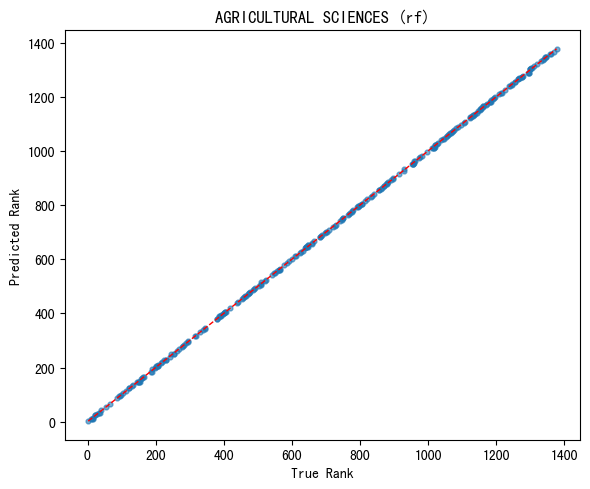

In [39]:
def plot_pred_vs_true(sdf_test: pd.DataFrame, yhat: np.ndarray, title=""):
    y = sdf_test["y"].values
    plt.figure(figsize=(6,5))
    plt.scatter(y, yhat, s=12, alpha=0.6)
    lim = [min(y.min(), yhat.min()), max(y.max(), yhat.max())]
    plt.plot(lim, lim, 'r--', lw=1)
    plt.xlabel('True Rank')
    plt.ylabel('Predicted Rank')
    plt.title(title)
    plt.tight_layout(); plt.show()
def evaluate_one_subject_example(subject_any: str, model_name='rf'):
    part = splits.get(subject_any)
    if not part:
        print('无该学科或样本过少')
        return
    pipe = train_model_for_subject(part['train'], model_name=model_name)
    metrics = evaluate_model(pipe, part['test'])
    display({k: v for k, v in metrics.items() if k != 'yhat'})
    plot_pred_vs_true(part['test'], metrics['yhat'], title=f'{subject_any} ({model_name})')
    return metrics
example_subject = next(iter(splits.keys())) if len(splits)>0 else None
if example_subject:
    _ = evaluate_one_subject_example(example_subject, model_name='rf')